In [1]:
!pip install patool

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.1/98.1 kB 3.0 MB/s eta 0:00:00


In [2]:
import os
import cv2
import numpy as np
import random
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import EarlyStopping

import itertools

import matplotlib.pyplot as plt


In [3]:
import patoolib

patoolib.extract_archive('/content/archive (1).zip')

INFO patool: Extracting /content/archive (1).zip ...
INFO:patool:Extracting /content/archive (1).zip ...
INFO patool: running /usr/bin/7z x -o./Unpack_livxcx0j -- "/content/archive (1).zip"
INFO:patool:running /usr/bin/7z x -o./Unpack_livxcx0j -- "/content/archive (1).zip"
INFO patool:     with input=''
INFO:patool:    with input=''
INFO patool: ... /content/archive (1).zip extracted to `archive (1)' (multiple files in root).
INFO:patool:... /content/archive (1).zip extracted to `archive (1)' (multiple files in root).


'archive (1)'

In [4]:
img = cv2.imread('/content/archive (1)/lfw-deepfunneled/lfw-deepfunneled/Aaron_Eckhart/Aaron_Eckhart_0001.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
print(len(img[0]))

250


Nestor_Santillan
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


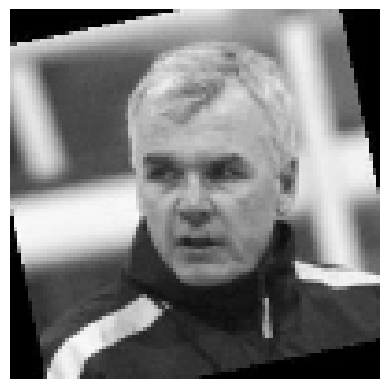

In [9]:
data_dir = "/content/archive (1)/lfw-deepfunneled/lfw-deepfunneled"
face_data = []
label_data = []

for label in os.listdir(data_dir):
    label_path = os.path.join(data_dir, label)

    if not os.path.isdir(label_path):
        continue

    for file_name in os.listdir(label_path):
        cur_path = os.path.join(label_path, file_name)
        cur_img = cv2.imread(cur_path)
        cur_img = cv2.resize(cur_img, (100, 100))
        cur_img = cv2.cvtColor(cur_img, cv2.COLOR_BGR2GRAY)
        face_data.append(cur_img)
        label_data.append(label)

print(label_data[0])
print(face_data[0])

plt.imshow(face_data[1], cmap='gray')
plt.axis('off')
plt.show()

In [10]:
face_array = np.array(face_data)
label_array = np.array(label_data)

print(face_array.shape)
print(label_array.shape)

(13233, 100, 100)
(13233,)


In [11]:
x_train, x_test, y_train, y_test = train_test_split(face_array, label_array, test_size=0.2, random_state=42)

# Check the shapes of the split arrays
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)

x_train shape: (10586, 100, 100)
y_train shape: (10586,)
x_test shape: (2647, 100, 100)
y_test shape: (2647,)


In [12]:
img_A_inp = Input((100, 100), name='img_A_inp')
img_B_inp = Input((100, 100), name='img_B_inp')

def get_cnn_block(depth):
  return Sequential([Conv2D(depth, 3, 1),
                     BatchNormalization(),
                     ReLU()])

DEPTH = 64
cnn = Sequential([Reshape((100, 100, 1)),
                  get_cnn_block(DEPTH),
                  get_cnn_block(DEPTH*2),
                  get_cnn_block(DEPTH*4),
                  get_cnn_block(DEPTH*8),
                  GlobalAveragePooling2D(),
                  Dense(64, activation='relu')])

feature_vector_A = cnn(img_A_inp)
feature_vector_B = cnn(img_B_inp)

concat = Concatenate()([feature_vector_A, feature_vector_B])

dense = Dense(64, activation='relu')(concat)
output = Dense(1, activation='sigmoid')(dense)

model = Model(inputs=[img_A_inp, img_B_inp], outputs=output)

model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ img_A_inp (InputLayer)    │ (None, 100, 100)       │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ img_B_inp (InputLayer)    │ (None, 100, 100)       │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_4 (Sequential) │ (None, 64)             │      1,586,496 │ img_A_inp[0][0],       │
│                           │                        │                │ img_B_inp[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 128)            │              0 │ sequential_4[0][0],    │
│                           │                        │                │ sequential_4[1][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 64)             │          8,256 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 1)              │             65 │ dense_1[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 1,594,817 (6.08 MB)

 Trainable params: 1,592,897 (6.08 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [13]:
random_indices = np.random.choice(x_train.shape[0], 300, replace=False)

X_train_sample, y_train_sample = x_train[random_indices], y_train[random_indices]

X_train_sample.shape, y_train_sample.shape

((300, 100, 100), (300,))

In [14]:
len(X_train_sample) ** 2

90000

In [15]:
def make_paired_dataset(X, y, num_pairs=10000):
    X_pairs, y_pairs = [], []

    for _ in range(num_pairs):
        idx_A, idx_B = random.sample(range(len(X)), 2)

        img_A, label_A = X[idx_A], y[idx_A]
        img_B, label_B = X[idx_B], y[idx_B]

        new_label = int(label_A == label_B)

        X_pairs.append([img_A, img_B])
        y_pairs.append(new_label)

    X_pairs = np.array(X_pairs)
    y_pairs = np.array(y_pairs)

    return X_pairs, y_pairs

In [16]:
make_paired_dataset(X_train_sample, y_train_sample)

(array([[[[  0,   0,   0, ...,   0,   0,   0],
          [  0,   0,   0, ...,   0,   0,   0],
          [  0,   0,   0, ...,   0,   0,   0],
          ...,
          [  0,   0,   0, ...,   0,   0,   0],
          [  0,   0,   0, ...,   0,   0,   0],
          [  0,   0,   0, ...,   0,   0,   0]],
 
         [[ 80,  45,  22, ...,   3,   3,   1],
          [ 75,  41,  19, ...,  41,  34,  31],
          [ 69,  40,  26, ..., 131, 128, 126],
          ...,
          [ 25,  26,  32, ..., 119, 124, 131],
          [ 26,  25,  29, ..., 115, 120, 128],
          [ 30,  27,  27, ..., 113, 118, 125]]],
 
 
        [[[  0,   0,   0, ...,   0,   0,   0],
          [  0,   0,   0, ...,   0,   0,   0],
          [  0,   0,   0, ...,   0,   0,   0],
          ...,
          [  0,   0,   0, ...,   0,   0,   0],
          [  0,   0,   0, ...,   0,   0,   0],
          [  0,   0,   0, ...,   0,   0,   0]],
 
         [[  0,   0,   0, ...,   0,   0,   0],
          [  0,   0,   0, ...,   0,   0,   0],
   

In [17]:
X_train_pairs, y_train_pairs = make_paired_dataset(X_train_sample, y_train_sample)

X_train_pairs.shape, y_train_pairs.shape

((10000, 2, 100, 100), (10000,))

In [18]:
random_indices = np.random.choice(x_test.shape[0], 150, replace=False)

X_test_sample, y_test_sample = x_test[random_indices], y_test[random_indices]

X_test_sample.shape, y_test_sample.shape

((150, 100, 100), (150,))

In [19]:
X_test_pairs, y_test_pairs = make_paired_dataset(X_test_sample, y_test_sample)

X_test_pairs.shape, y_test_pairs.shape

((10000, 2, 100, 100), (10000,))

In [20]:
model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])

In [21]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(patience=3)

In [22]:
model.fit(x=[X_train_pairs[:, 0, :, :], X_train_pairs[:, 1, :, :]],
          y=y_train_pairs,
          validation_data=([X_test_pairs[:, 0, :, :],
                            X_test_pairs[:, 1, :, :]],
                           y_test_pairs),
          epochs=10,
          batch_size=32,
          callbacks=[es])

Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 426s 1s/step - accuracy: 0.9893 - loss: 0.0539 - val_accuracy: 0.9965 - val_loss: 0.0271
Epoch 2/10


KeyboardInterrupt: 

In [23]:
img_A, img_B = x_test[0], x_test[17]
label_A, label_B = y_test[0], y_test[17]

label_A, label_B

('Angie_Arzola', 'Mike_Helton')

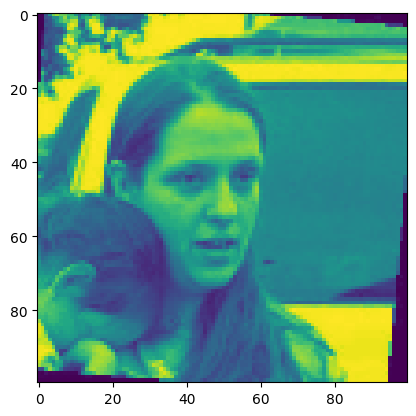

In [27]:
plt.figure(dpi=100)
plt.imshow(img_A)

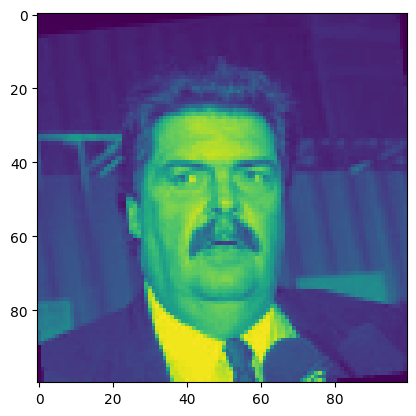

In [28]:
plt.figure(dpi=100)
plt.imshow(img_B)

In [29]:
model.predict([img_A.reshape((1, 100, 100)),
               img_B.reshape((1, 100, 100))]).flatten()[0] > 0.5

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


False

In [30]:
model.save("my_model.h5")

In [31]:
model.save("my_model.keras")

In [36]:
len(os.listdir('/content/archive (1)/lfw-deepfunneled/lfw-deepfunneled'))

unique_strings, counts = np.unique(y_train_sample, return_counts=True)

duplicates = unique_strings[counts > 1]
print(len(unique_strings))

251
